# A Review on Predictive Modeling for Adrenocortical Carcinoma

## Imports and dataset name definitions

In [1]:
# Dataset API
import xenaPython as xena

# Plotting and calculations
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#Training imports
from lifelines import KaplanMeierFitter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer

host = "https://gdc.xenahubs.net"

# Copy Number
dataset_copy_number = "TCGA-ACC.cnv.tsv"
dataset_masked_copy_number = "TCGA-ACC.masked_cnv.tsv"
dataset_copy_number_by_gene = "TCGA-ACC.gistic.tsv"

# DNA Methylation
dataset_dna_methylation = "TCGA-ACC.methylation450.tsv"

# Gene Expression
dataset_htseq_counts = "TCGA-ACC.htseq_counts.tsv"
dataset_htseq_fpkm = "TCGA-ACC.htseq_fpkm.tsv"
dataset_htseq_fpkm_uq = "TCGA-ACC.htseq_fpkm-uq.tsv"

# Phenotype
dataset_phenotype = "TCGA-ACC.GDC_phenotype.tsv"

# Survival Data
dataset_survival_data = "TCGA-ACC.survival.tsv"

# Somatic Mutation
dataset_muse_snv = "TCGA-ACC.muse_snv.tsv"
dataset_mutect2_snv = "TCGA-ACC.mutect2_snv.tsv"
dataset_somaticsniper_snv = "TCGA-ACC.somaticsniper_snv.tsv"
dataset_carscan2_snv = "TCGA-ACC.varscan2_snv.tsv"

# Stem Loop Expression
dataset_mirna = "TCGA-ACC.mirna.tsv"


c:\Users\danbr\anaconda3\Lib\site-packages\xenaPython\__init__.py:109: FutureWarning: Possible nested set at position 7
  re.sub(r"^[^[]+[[]([^]]*)[]].*$", r"\1", query, flags=re.DOTALL))


## Import Copy Number Data

In [2]:
segment_data = xena.segment_data_examples(host, dataset_masked_copy_number, None)

# Flatten the nested data
flattened_data = {
    'sampleID': segment_data['rows']['sampleID'],
    'chromosome': [pos['chrom'] for pos in segment_data['rows']['position']],
    'chromstart': [pos['chromstart'] for pos in segment_data['rows']['position']],
    'chromend': [pos['chromend'] for pos in segment_data['rows']['position']],
    'strand': [pos['strand'] for pos in segment_data['rows']['position']],
    'value': segment_data['rows']['value']
}

# Convert to DataFrame
df_copy_number = pd.DataFrame(flattened_data)

## Generate Heat Map of Copy Number Variations

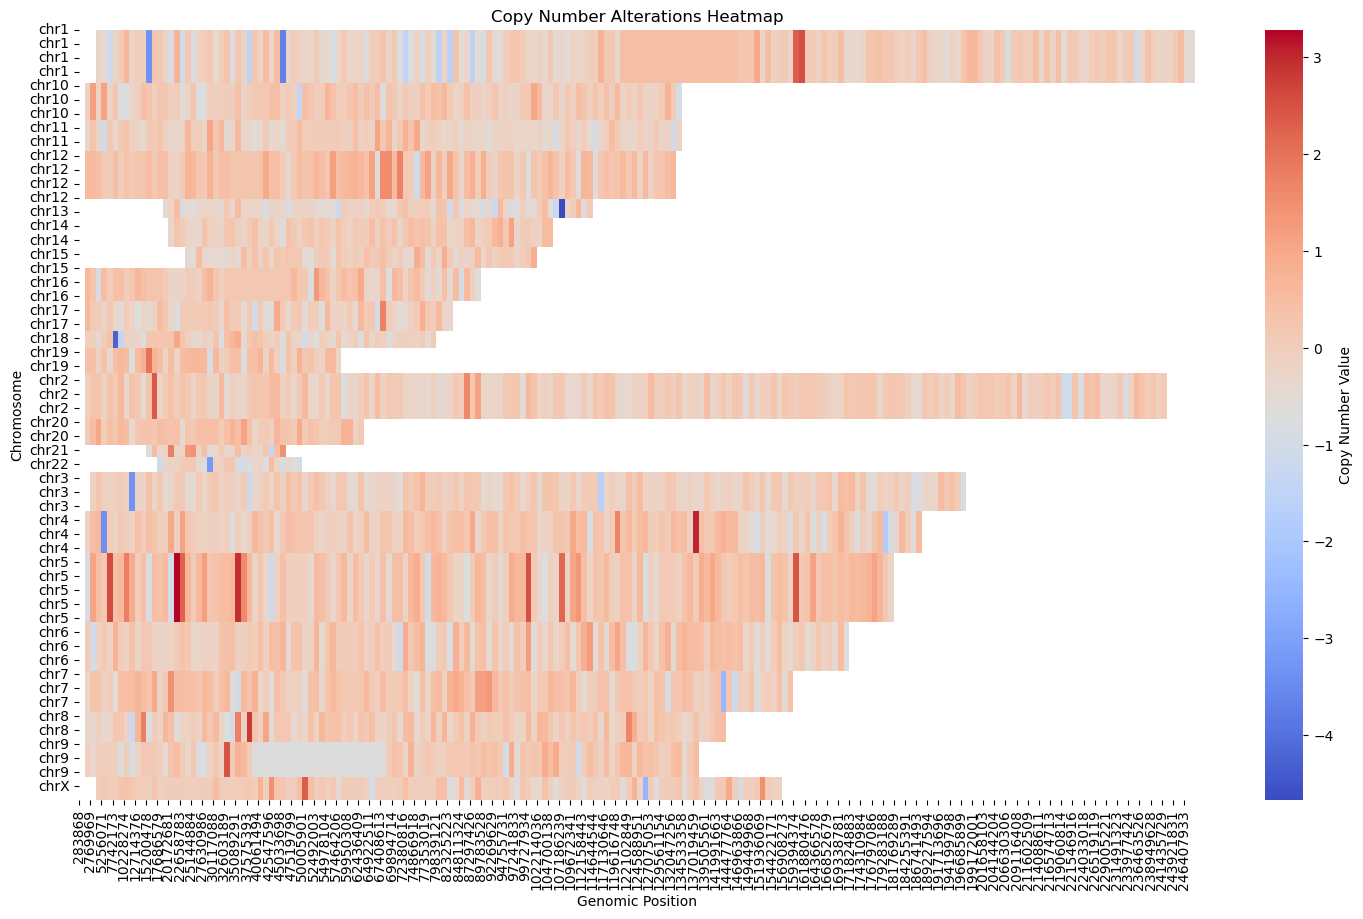

In [3]:
# Number of bins
num_bins = 200

# Calculate bin width
bin_width = (df_copy_number['chromend'].max() - df_copy_number['chromstart'].min()) / num_bins

# Create bins
bins = np.linspace(df_copy_number['chromstart'].min(), df_copy_number['chromend'].max(), num_bins)

# New dataframe for binned copy number values
binned_df = pd.DataFrame(index=df_copy_number['chromosome'], columns=bins)

for index, row in df_copy_number.iterrows():
    # Calculate the bin index for chromstart and chromend
    start_bin = np.digitize(row['chromstart'], bins)
    end_bin = np.digitize(row['chromend'], bins)
    
    # Assign the copy number value to all bins within the range
    binned_df.loc[row['chromosome'], bins[start_bin:end_bin]] = row['value']

# Convert data to float
binned_df = binned_df.astype(float)

# Plot heatmap
plt.figure(figsize=(18, 10))
sns.heatmap(binned_df, cmap='coolwarm', cbar_kws={'label': 'Copy Number Value'})

# Calculate the step size for xticks
step_size = len(bins) // 80

# Round positions to integers
plt.xticks(np.arange(0, len(bins), step_size), [int(bins[i]) for i in range(0, len(bins), step_size)])

plt.xlabel('Genomic Position')
plt.ylabel('Chromosome')
plt.title('Copy Number Alterations Heatmap')
plt.show()

## Plot copy value segments for each chromosome

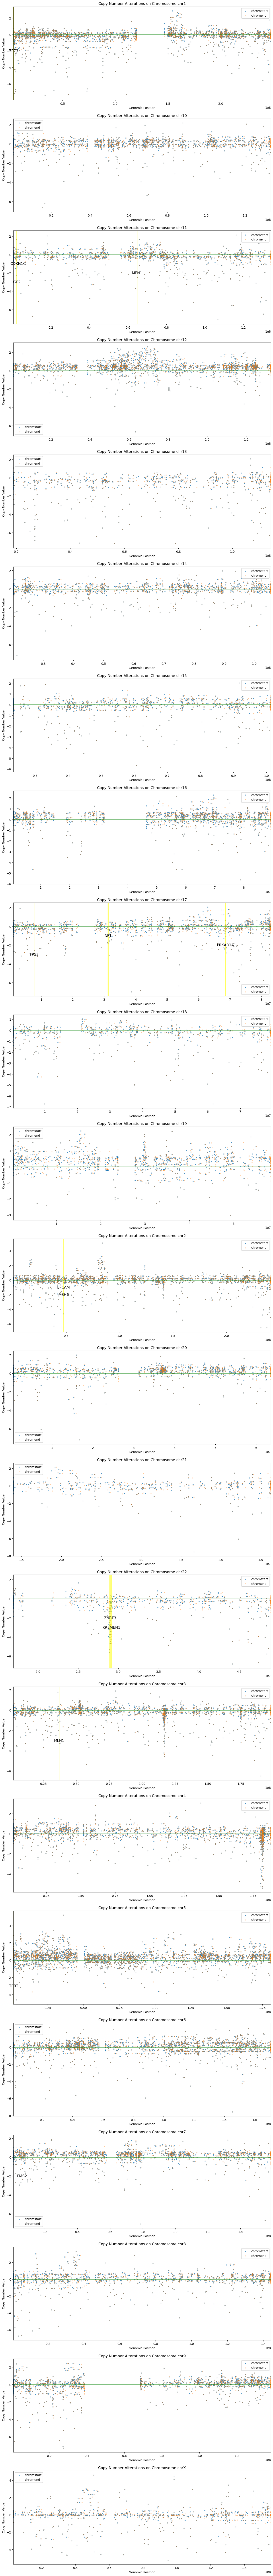

In [12]:
labels = ['TP73', 'IGF2','CDKN1C','MEN1','TP53','NF1','PRKAR1A','EPCAM','MSH6','ZNRF3','KREMEN1','MLH1', 'TERT','PMS2']
probes = ['ENSG00000078900.13','ENSG00000167244.16', 'ENSG00000129757.11', 'ENSG00000133895.13', 'ENSG00000141510.14', 'ENSG00000196712.15', 'ENSG00000108946.13', 'ENSG00000119888.9', 'ENSG00000116062.13', 'ENSG00000183579.14', 'ENSG00000183762.11', 'ENSG00000076242.13', 'ENSG00000164362.17', 'ENSG00000122512.13']
starts = [3652520, 2129112, 2883213, 64803510, 7661779, 31094927, 68511780, 47345158, 47695530, 28883592, 29073078, 36993332, 1253147, 5973239]

starts_to_label = dict(zip(starts, labels))

unique_chromosomes = df_copy_number['chromosome'].unique()

# Get probe data
samples = xena.dataset_samples(host, dataset_copy_number_by_gene, None)
probes_data = xena.dataset_probe_values(host, dataset_copy_number_by_gene, samples, probes)

# Create subplots for each chromosome
plt.figure(figsize=(15, 150))
for i, chromosome in enumerate(unique_chromosomes):
    plt.subplot(len(unique_chromosomes), 1, i+1)
    chromosome_data = df_copy_number[df_copy_number['chromosome'] == chromosome]
    plt.scatter(chromosome_data['chromstart'], chromosome_data['value'], s=5, alpha=0.7, label='chromstart')
    plt.scatter(chromosome_data['chromend'], chromosome_data['value'], s=5, alpha=0.3, label='chromend')
    plt.axhline(0, color='green', lw=2, alpha=0.5)
    plt.xlabel('Genomic Position')
    plt.ylabel('Copy Number Value')
    plt.title(f'Copy Number Alterations on Chromosome {chromosome}')
    plt.legend()
    plt.xlim(min(min(chromosome_data['chromstart']), min(chromosome_data['chromend'])), max(max(chromosome_data['chromstart']), max(chromosome_data['chromend'])))

    # Add yellow bars for probes
    for probe in probes_data[0]:
        if probe['chrom'] == chromosome:
            x_start = probe['chromstart']
            x_end = probe['chromend']  
            plt.axvspan(x_start, x_end, color='yellow', alpha=0.5)
            positions = [-1,-2,-3] # Positions for the labels so they don't overlap (hopefully)
            plt.text((x_start + x_end) / 2, np.random.choice(positions), starts_to_label.get(x_start), horizontalalignment='center', verticalalignment='center', fontsize=12, color='black')
plt.show()

## Calculate Correlation between CNV and gene expression data

In [14]:
labels = ['TP73', 'IGF2','CDKN1C','MEN1','TP53','NF1','PRKAR1A','EPCAM','MSH6','ZNRF3','KREMEN1','MLH1', 'TERT','PMS2']
probes = ['ENSG00000078900.13','ENSG00000167244.16', 'ENSG00000129757.11', 'ENSG00000133895.13', 'ENSG00000141510.14', 'ENSG00000196712.15', 'ENSG00000108946.13', 'ENSG00000119888.9', 'ENSG00000116062.13', 'ENSG00000183579.14', 'ENSG00000183762.11', 'ENSG00000076242.13', 'ENSG00000164362.17', 'ENSG00000122512.13']

# Get samples
samples = xena.dataset_samples(host, dataset_htseq_fpkm_uq, None)

# Retrieve probe values for the given samples
probe_values_expression = xena.dataset_probe_values(host, dataset_htseq_fpkm_uq, samples, probes)
probe_values_copy_number = xena.dataset_probe_values(host, dataset_copy_number_by_gene, samples, probes)

correlation_values = []

for i in range(len(probe_values_expression[1])):
    expression_values = probe_values_expression[1][i]
    copy_number_values = probe_values_copy_number[1][i]

    expression_values = [np.nan if x == 'NaN' else x for x in expression_values]
    copy_number_values = [np.nan if x == 'NaN' else x for x in copy_number_values]

    data = pd.DataFrame({'Expression Values': expression_values, 'Copy Number Data': copy_number_values})

    # Correlation analysis
    correlation = data['Expression Values'].corr(data['Copy Number Data'])
    correlation_values.append(correlation)

# Create a DataFrame with probe IDs and correlation values
correlation_df = pd.DataFrame({'Gene': labels, 'Probe ID': probes, 'Correlation': correlation_values})

# Print the DataFrame
correlation_df

,Gene,Probe ID,Correlation
0,TP73,ENSG00000078900.13,-0.012363
1,IGF2,ENSG00000167244.16,-0.056969
2,CDKN1C,ENSG00000129757.11,0.139564
3,MEN1,ENSG00000133895.13,0.523027
4,TP53,ENSG00000141510.14,0.321960
5,NF1,ENSG00000196712.15,0.173624
6,PRKAR1A,ENSG00000108946.13,0.221999
7,EPCAM,ENSG00000119888.9,-0.117187
8,MSH6,ENSG00000116062.13,0.198753
9,ZNRF3,ENSG00000183579.14,0.291863


## Build a DataFrame with Phenotype data and generate visualizations

In [15]:
# Get a list of samples
samples_phenotype = xena.dataset_samples(host, dataset_phenotype, None)

fields = ["age_at_diagnosis.diagnoses", "age_at_index.demographic", "age_at_initial_pathologic_diagnosis", 
          "alcohol_history.exposures", "atypical_mitotic_figures", "batch_number", "bcr", "bcr_followup_barcode", 
          "bcr_followup_uuid", "bcr_id.tissue_source_site", "classification_of_tumor.diagnoses", "clinical_M", 
          "code.tissue_source_site", "ct_scan", "ct_scan_findings", "cytoplasm_presence_less_than_equal_25_percent",
          "day_of_dcc_upload", "days_to_birth.demographic", "days_to_death.demographic", "days_to_diagnosis.diagnoses", 
          "days_to_index", "days_to_initial_pathologic_diagnosis", "days_to_last_follow_up.diagnoses", "diffuse_architecture",
          "disease_type", "ethnicity.demographic", "gender.demographic", "history_of_neoadjuvant_treatment",
          "initial_weight.samples", "invasion_of_tumor_capsule", "last_known_disease_status.diagnoses", "laterality",
          "lost_follow_up", "metastatic_neoplasm_confirmed_diagnosis_method_text", "mitoses_count", "mitotane_therapy",
          "mitotane_therapy_adjuvant_setting", "mitotic_rate", "morphology.diagnoses", "name.tissue_source_site", 
          "necrosis", "nuclear_grade_III_IV", "number_of_lymphnodes_positive_by_he", "oct_embedded.samples", "pathologic_N", 
          "pathologic_T", "person_neoplasm_cancer_status", "post_surgical_procedure_assessment_thyroid_gland_carcinoma_status", 
          "postoperative_rx_tx", "primary_lymph_node_presentation_assessment", "primary_therapy_outcome_success", 
          "prior_malignancy.diagnoses", "prior_treatment.diagnoses", "progression_or_recurrence.diagnoses", "project.tissue_source_site",
          "race.demographic", "radiation_therapy", "ret", "sinusoid_invasion", "site_of_resection_or_biopsy.diagnoses", "state.samples",
          "synchronous_malignancy.diagnoses", "therapeutic_mitotane_levels_achieved", "therapeutic_mitotane_lvl_macroscopic_residual",
          "therapeutic_mitotane_lvl_progression", "therapeutic_mitotane_lvl_recurrence", "tissue_retrospective_collection_indicator",
          "tumor_grade.diagnoses", "tumor_stage.diagnoses", "vital_status.demographic", "weiss_score", "weiss_venous_invasion",
          "year_of_birth.demographic", "year_of_death.demographic", "year_of_diagnosis.diagnoses", "year_of_initial_pathologic_diagnosis"]

# Retrieve probe values for the given samples
probe_values_phenotype = xena.dataset_probe_values(host, dataset_phenotype, samples_phenotype, fields)

# Phenotype data to DataFrame
data = {
    'sampleID': samples_phenotype,
}

for field, values in zip(fields, probe_values_phenotype[1]):
    data[field] = values

phenotype_df = pd.DataFrame(data)

In [16]:
# Get a list of samples
samples_survival = xena.dataset_samples(host, dataset_survival_data, None)

fields = ["OS", "OS.time"]

# Retrieve probe values for the given samples
probe_values_survival = xena.dataset_probe_values(host, dataset_survival_data, samples_survival, fields)

# Organize phenotype data into a DataFrame
data = {
    'sampleID': samples_survival,
}

for field, values in zip(fields, probe_values_survival[1]):
    data[field] = values

phenotype_survival_df = pd.DataFrame(data)
merged_phenotype = pd.merge(phenotype_df, phenotype_survival_df, on='sampleID', how='inner')

### Visualizations

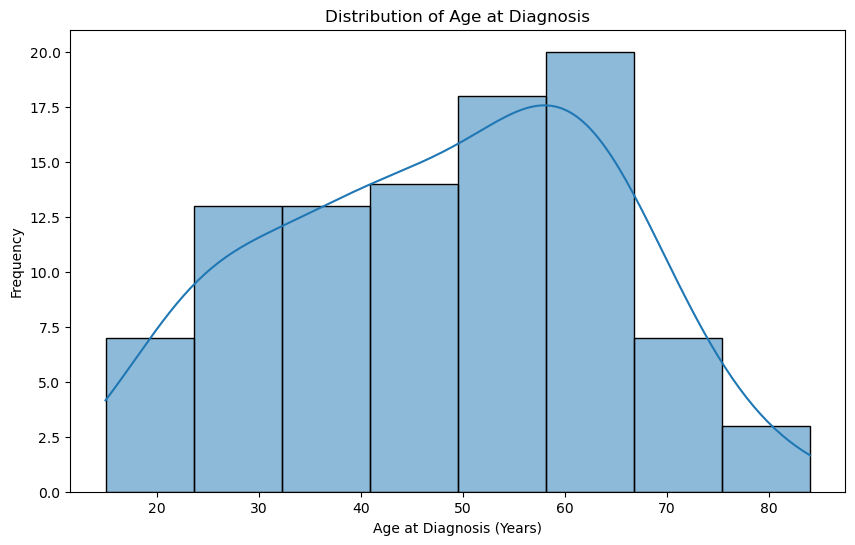

In [17]:
# Distribution of age at diagnosis in years
plt.figure(figsize=(10, 6))
sns.histplot((merged_phenotype['age_at_diagnosis.diagnoses'] / 365).round(), kde=True)
plt.title('Distribution of Age at Diagnosis')
plt.xlabel('Age at Diagnosis (Years)')
plt.ylabel('Frequency')
plt.show()

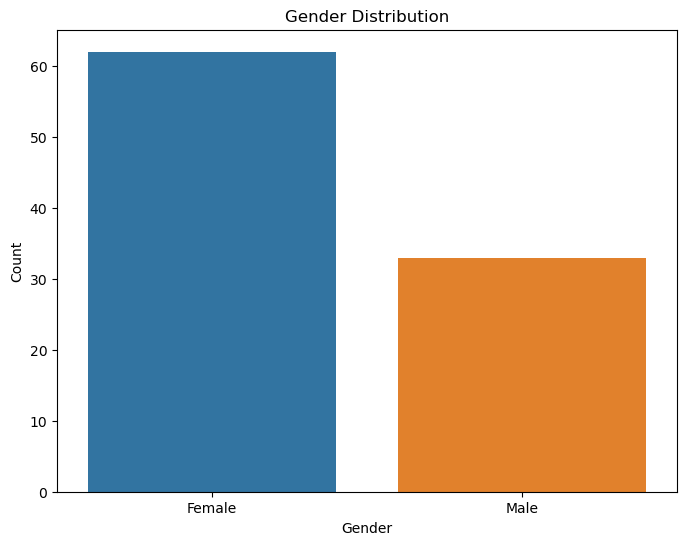

In [18]:
# Gender distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=merged_phenotype, x='gender.demographic')
plt.xticks(ticks=[0, 1], labels=['Female', 'Male'])
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

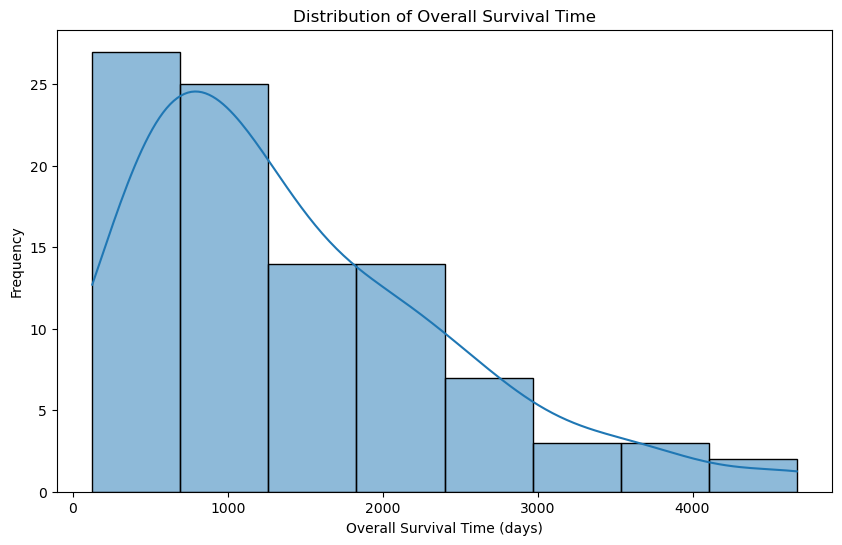

In [19]:
# Distribution of overall survival time
plt.figure(figsize=(10, 6))
sns.histplot(merged_phenotype['OS.time'].dropna(), kde=True)
plt.title('Distribution of Overall Survival Time')
plt.xlabel('Overall Survival Time (days)')
plt.ylabel('Frequency')
plt.show()

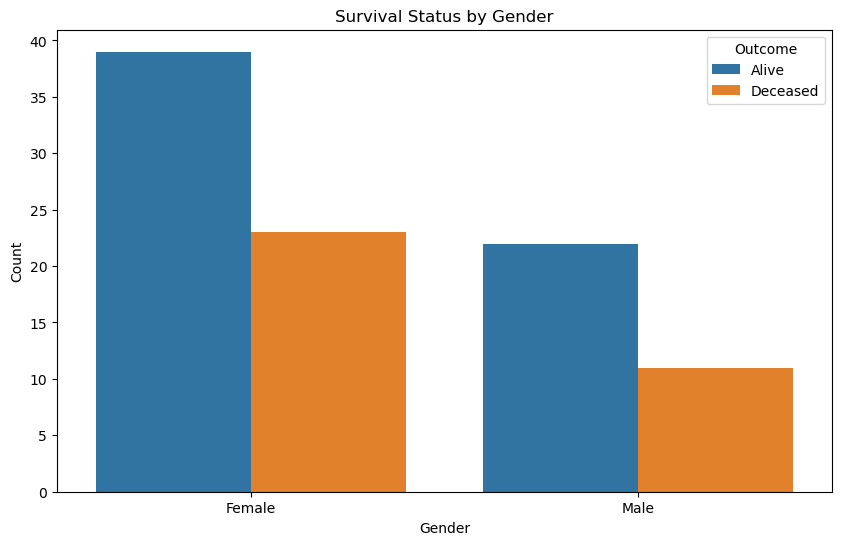

In [20]:
# Survival status by gender
plt.figure(figsize=(10, 6))
sns.countplot(data=merged_phenotype, x='gender.demographic', hue='OS')
plt.xticks(ticks=[0, 1], labels=['Female', 'Male'])
plt.title('Survival Status by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Outcome', labels=['Alive', 'Deceased'])
plt.show()

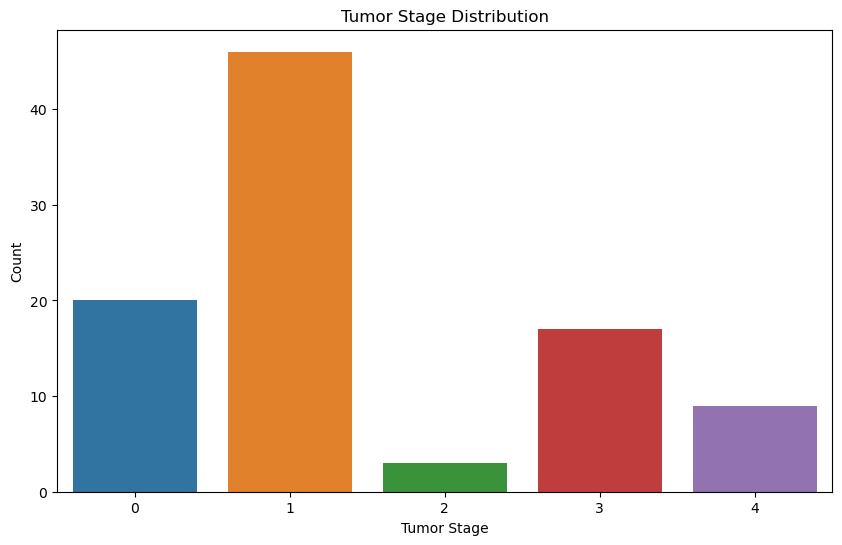

In [21]:
# Tumor stage distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=merged_phenotype, x='tumor_stage.diagnoses')
plt.title('Tumor Stage Distribution')
plt.xlabel('Tumor Stage')
plt.ylabel('Count')
plt.show()

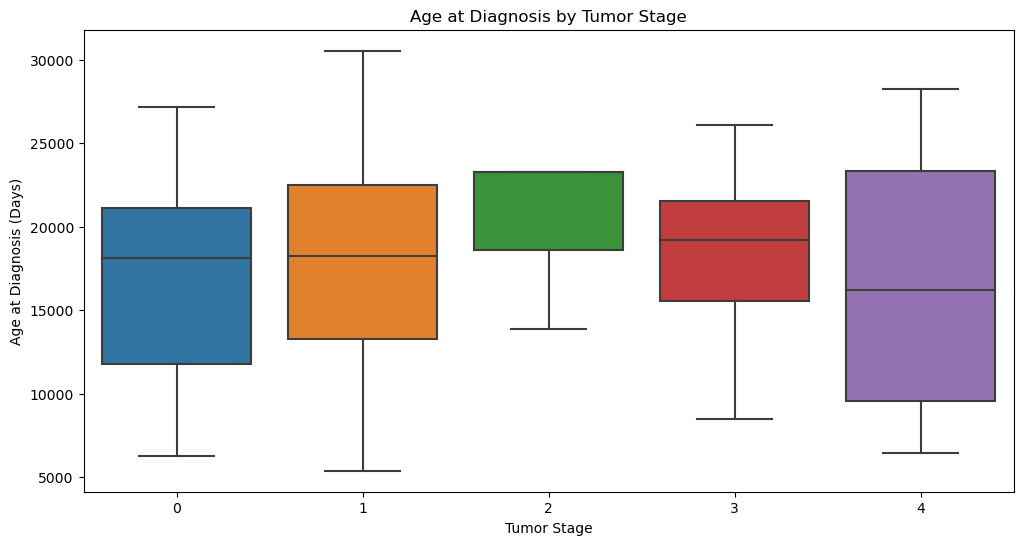

In [22]:
# Boxplot of age at diagnosis by tumor stage
plt.figure(figsize=(12, 6))
sns.boxplot(data=merged_phenotype, x='tumor_stage.diagnoses', y='age_at_diagnosis.diagnoses')
plt.title('Age at Diagnosis by Tumor Stage')
plt.xlabel('Tumor Stage')
plt.ylabel('Age at Diagnosis (Days)')
plt.show()

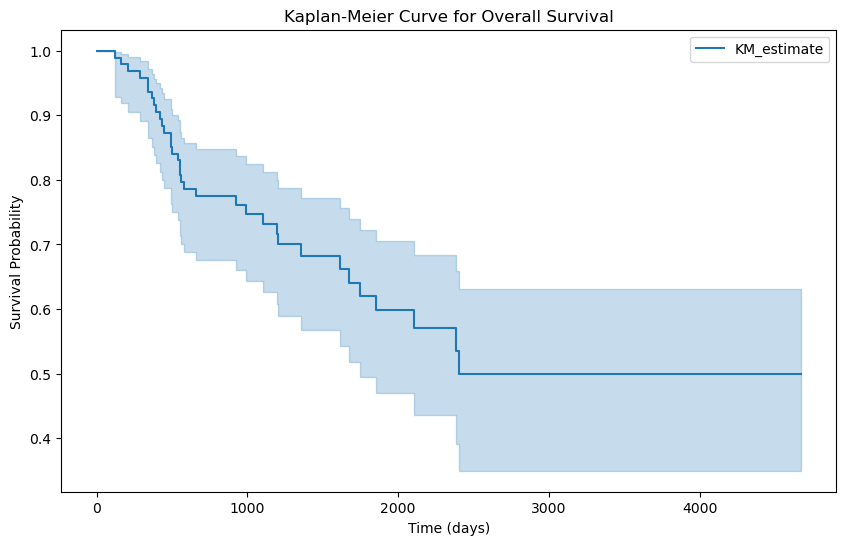

In [23]:
# Kaplan-Meier curve for survival
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))
kmf.fit(durations=merged_phenotype['OS.time'], event_observed=merged_phenotype['OS'])
kmf.plot_survival_function()
plt.title('Kaplan-Meier Curve for Overall Survival')
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability')
plt.show()

## Generating heat map for features of the thenotype

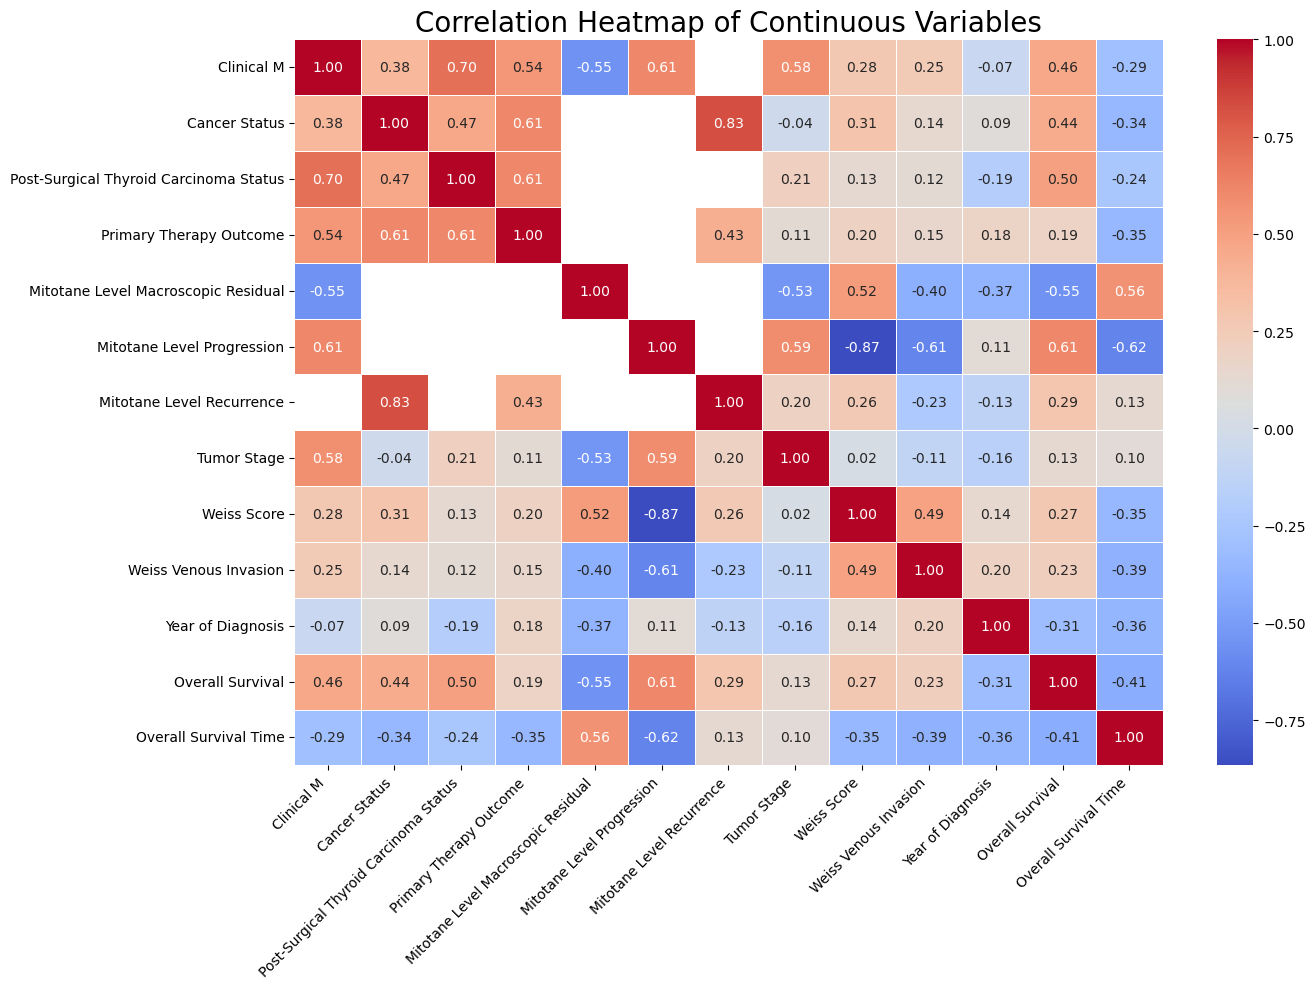

In [24]:
# Original names and labels map
rename_dict = {
    "clinical_M": "Clinical M",
    "person_neoplasm_cancer_status": "Cancer Status",
    "post_surgical_procedure_assessment_thyroid_gland_carcinoma_status": "Post-Surgical Thyroid Carcinoma Status",
    "primary_therapy_outcome_success": "Primary Therapy Outcome",
    "therapeutic_mitotane_lvl_macroscopic_residual": "Mitotane Level Macroscopic Residual",
    "therapeutic_mitotane_lvl_progression": "Mitotane Level Progression",
    "therapeutic_mitotane_lvl_recurrence": "Mitotane Level Recurrence",
    "tumor_stage.diagnoses": "Tumor Stage",
    "weiss_score": "Weiss Score",
    "weiss_venous_invasion": "Weiss Venous Invasion",
    "year_of_diagnosis.diagnoses": "Year of Diagnosis",
    "OS": "Overall Survival",
    "OS.time": "Overall Survival Time"
}

# Selecting a subset of continuous variables
continuous_vars = list(rename_dict.keys())

# Rename columns in the DataFrame
renamed_df = merged_phenotype[continuous_vars].rename(columns=rename_dict)

# Calculate the correlation matrix
correlation_matrix = renamed_df.corr()

# Plot the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5, fmt=".2f")
plt.title('Correlation Heatmap of Continuous Variables', fontsize=20)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks( fontsize=10)
plt.tight_layout()
plt.show()


## Training Predictive Models

### Building the trainig dataset and preprocessing

In [26]:
labels = ['MEN1','TP53','PRKAR1A', 'MSH6','ZNRF3','KREMEN1','TERT']
probes = ['ENSG00000133895.13', 'ENSG00000141510.14', 'ENSG00000108946.13', 'ENSG00000116062.13', 'ENSG00000183579.14', 'ENSG00000183762.11', 'ENSG00000164362.17']
fields = ["clinical_M","person_neoplasm_cancer_status","post_surgical_procedure_assessment_thyroid_gland_carcinoma_status","primary_therapy_outcome_success","therapeutic_mitotane_lvl_macroscopic_residual","therapeutic_mitotane_lvl_progression","therapeutic_mitotane_lvl_recurrence","tumor_stage.diagnoses","weiss_score","weiss_venous_invasion","year_of_diagnosis.diagnoses"]

# Get a list of samples
samples = xena.dataset_samples(host, dataset_phenotype, None) # Has the largest set of samples

# Retrieve probe values for the given samples
probe_values_phenotype = xena.dataset_probe_values(host, dataset_phenotype, samples, fields)

# Organize phenotype data into a DataFrame
data = {
    'sampleID': samples_phenotype,
}

for field, values in zip(fields, probe_values_phenotype[1]):
    data[field] = values

phenotype_df = pd.DataFrame(data)

In [27]:
# Get a list of samples
samples_survival = xena.dataset_samples(host, dataset_survival_data, None)

# Fetch metadata for fields in the phenotype dataset
phenotype_survival = xena.all_field_metadata(host, dataset_survival_data)

fields_os = ["OS", "OS.time"]

# Retrieve probe values for the given samples
probe_values_survival = xena.dataset_probe_values(host, dataset_survival_data, samples_survival, fields_os)

# Organize phenotype data into a DataFrame
data = {
    'sampleID': samples_survival,
}

for field, values in zip(fields_os, probe_values_survival[1]):
    data[field] = values

phenotype_survival_df = pd.DataFrame(data)
merged_phenotype = pd.merge(phenotype_df, phenotype_survival_df, on='sampleID', how='inner')

In [28]:
# Retrieve probe values for the given samples
probe_values_expression = xena.dataset_probe_values(host, dataset_htseq_fpkm_uq, samples, probes)

# Retrieve probe values for the given samples
probe_values_copy_number = xena.dataset_probe_values(host, dataset_copy_number_by_gene, samples, probes)

merged_data = merged_phenotype

for i, probe_id in enumerate(probes):
    expression_values = probe_values_expression[1][i]
    copy_number_values = probe_values_copy_number[1][i]

    expression_values = [np.nan if x == 'NaN' else x for x in expression_values]
    copy_number_values = [np.nan if x == 'NaN' else x for x in copy_number_values]

    data = pd.DataFrame({'sampleID': samples, 'Expression Values': expression_values, 'Copy Number Data': copy_number_values})
    
    # Add numbered columns using the probe ID
    data.columns = [f"{col} ({probe_id})" for col in data.columns]

    data.rename(columns={f"sampleID ({probe_id})": "sampleID"}, inplace=True)

    merged_data = pd.merge(merged_data, data, on='sampleID', how='inner')

df = merged_data
df.drop('sampleID', axis=1, inplace=True)

### Training models

c:\Users\danbr\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


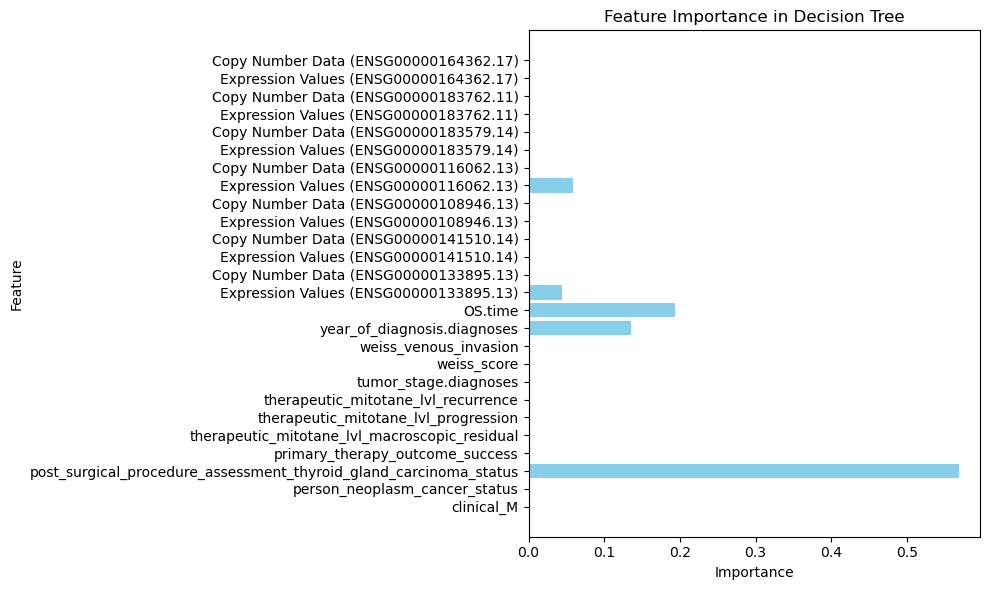

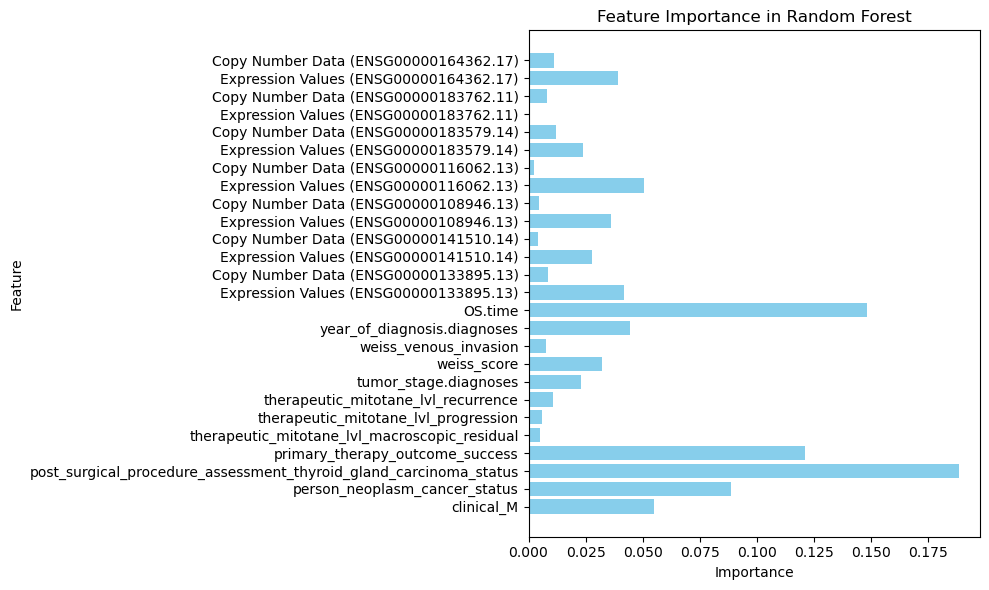

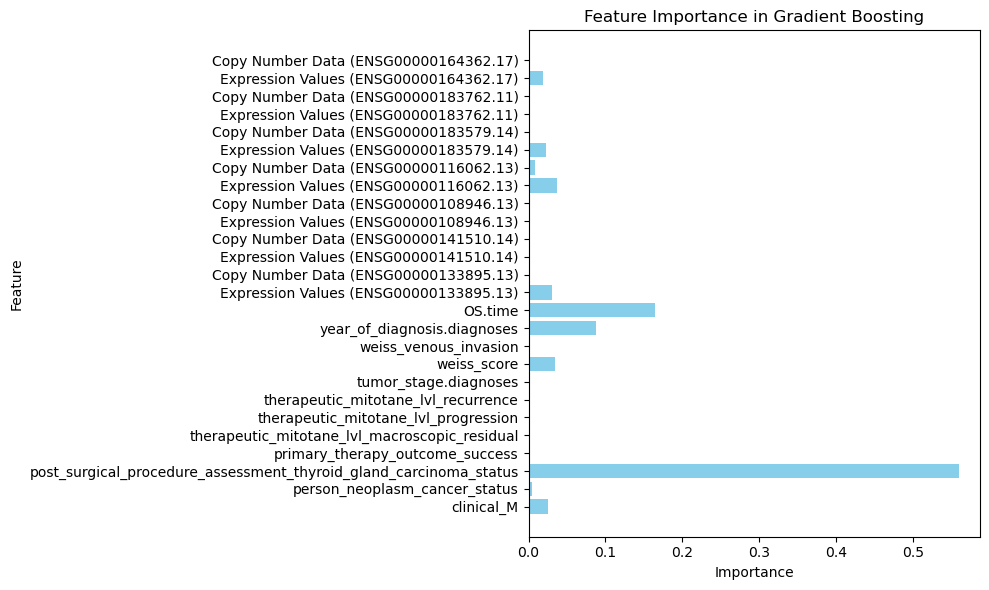

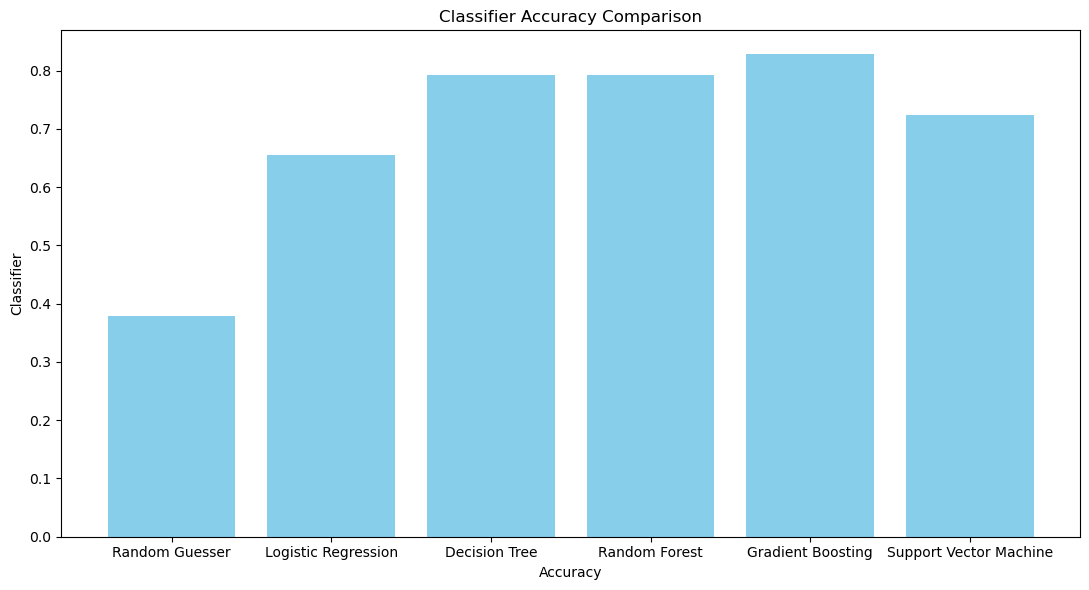

In [29]:
# Step 1: Handle missing values
imputer = SimpleImputer(strategy='mean')
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# Step 2: Split the dataset into features (X) and target variable (y)
X = df_imputed.drop('OS', axis=1)  # Features
y = df_imputed['OS']  # Target variable

# Step 3: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Results dictionary to store classifier names and their accuracies
results = {}

# Step 4: Initialize and train classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Support Vector Machine': SVC()
}

# Random guesser to compare with
random_guesser_accuracy = np.mean(y_test)
results['Random Guesser'] = random_guesser_accuracy

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    # Evaluate classifier
    accuracy = accuracy_score(y_test, y_pred)
    
    # Store results
    results[name] = accuracy
    
    # Check if the classifier supports feature importances
    if hasattr(clf, 'feature_importances_'):
        # Get feature importances
        feature_importances = clf.feature_importances_

        # Get feature names
        feature_names = list(X.columns)

        # Create a bar plot of feature importances
        plt.figure(figsize=(10, 6))
        plt.barh(feature_names, feature_importances, color='skyblue')

        # Add labels and title
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.title(f'Feature Importance in {name}')

        # Show plot
        plt.tight_layout()
        plt.show()

# Create a bar plot for classifier accuracies
plt.figure(figsize=(11, 6))
plt.bar(results.keys(), results.values(), color='skyblue')

# Add labels and title
plt.ylabel('Classifier')
plt.xlabel('Accuracy')
plt.title('Classifier Accuracy Comparison')

# Show plot
plt.tight_layout()
plt.show()